## Exploring house prices xxx postal codes (Simple approach)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from scipy.stats.stats import pearsonr

In [2]:
houses_df =  pd.read_csv('./Datasets/train.csv')

In [3]:
houses_test = pd.read_csv('./Datasets/test.csv')

## Let's expand our availabe columns for study

In [4]:
list(houses_df.columns)

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF'

## and running a basic EDA

In [5]:
houses_df['LandContour'].value_counts()

Lvl    1311
Bnk      63
HLS      50
Low      36
Name: LandContour, dtype: int64

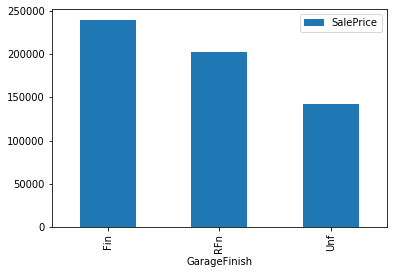

In [6]:
AvgPrices = pd.DataFrame(houses_df.groupby(['GarageFinish'])['SalePrice'].mean()).plot(kind='bar')

In [7]:
HouseFtrs = houses_df.loc[:,['SaleType','SaleCondition','BedroomAbvGr','MiscVal',
          'KitchenAbvGr','EnclosedPorch','FireplaceQu','LotArea', 'Foundation',
          'TotalBsmtSF','GarageFinish','SalePrice']]

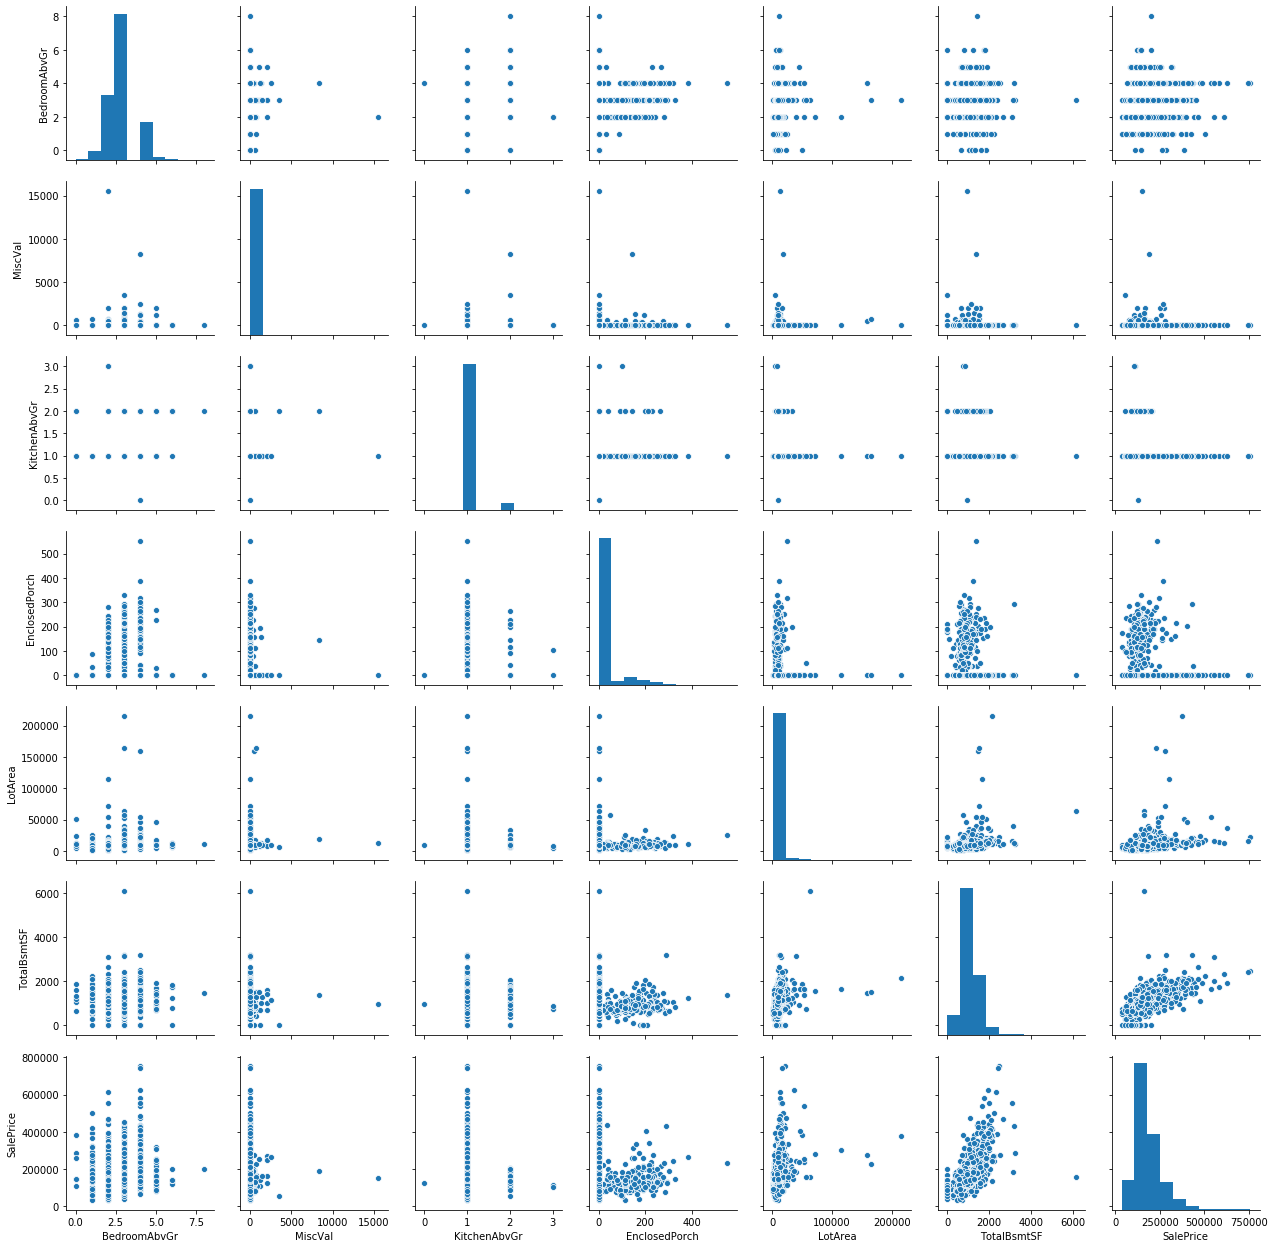

In [8]:
import seaborn as sns
sns.pairplot(HouseFtrs)

In [9]:
HouseFtrs1 = houses_df.loc[:,['LotArea','BedroomAbvGr','SalePrice']]

So far there is a good differentiation 
between the effect of categorical and nummerical  variables. I will use
the next set of features that look relevant

In [10]:
features1 = HouseFtrs1.columns.tolist()
for x_ in features1:
    for y_ in features1:
        if(x_!=y_):
            print('x: {} \ny: {}'.format(x_,y_))
            a=HouseFtrs[x_]
            b=HouseFtrs[y_]
            r_cor ,p_val =pearsonr(a,b)
            print('the correlation is {}'.format(r_cor))
        else:
            continue

x: LotArea 
y: BedroomAbvGr
the correlation is 0.11968990815131571
x: LotArea 
y: SalePrice
the correlation is 0.2638433538714057
x: BedroomAbvGr 
y: LotArea
the correlation is 0.11968990815131571
x: BedroomAbvGr 
y: SalePrice
the correlation is 0.16821315430073996
x: SalePrice 
y: LotArea
the correlation is 0.2638433538714057
x: SalePrice 
y: BedroomAbvGr
the correlation is 0.16821315430073996


In [11]:
HouseFtrs.isna().sum()

SaleType           0
SaleCondition      0
BedroomAbvGr       0
MiscVal            0
KitchenAbvGr       0
EnclosedPorch      0
FireplaceQu      690
LotArea            0
Foundation         0
TotalBsmtSF        0
GarageFinish      81
SalePrice          0
dtype: int64

In [12]:
HouseFtrs['FireplaceQu'].fillna('Unknown', inplace=True)


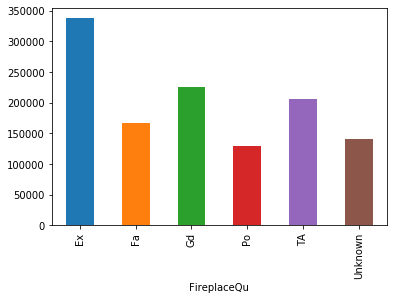

In [13]:
HouseFtrs.groupby(['FireplaceQu'])['SalePrice'].mean().plot(kind='bar')

# Let's start the ML model import training and prection processes

In [16]:
import lightgbm
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.model_selection import  GridSearchCV

In [17]:
X_train = HouseFtrs.copy()
y_act = pd.DataFrame(X_train['SalePrice'].copy(),columns=['SalePrice'])
del X_train['SalePrice']

In [18]:
features = ['SaleType','SaleCondition','BedroomAbvGr','MiscVal',
            'KitchenAbvGr','EnclosedPorch','FireplaceQu','LotArea',
            'Foundation','TotalBsmtSF','GarageFinish'
           ]

X_test = houses_test.loc[:,features]

In [19]:
X_test.fillna({'SaleType':'unknown','FireplaceQu':'NA','GarageFinish':'NA'},inplace=True)

In [20]:
X_test = X_test[X_test['TotalBsmtSF'].notnull()]

# training and validating the model

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train, x_test, y_train, y_test = train_test_split(HouseFtrs.drop(['SalePrice'],axis=1),
                                                   HouseFtrs['SalePrice'],
                                                   shuffle=True,
                                                   test_size=0.35,random_state=89)

In [23]:
x_train.fillna({'FireplaceQu':'NA','Foundation':'NAvail','GarageFinish':'Unknown'},inplace=True)
x_test.fillna({'FireplaceQu':'NA','Foundation':'NAvail','GarageFinish':'Unknown'},inplace=True)

In [24]:
from sklearn.preprocessing import LabelEncoder

LE1 = LabelEncoder()

categ_cols =(x_train.select_dtypes('object').columns).tolist()
for col in categ_cols:    
    x_train[col] = LE1.fit_transform(x_train[col])
    x_test[col] = LE1.fit_transform(x_test[col])
    print(col,'...clean and transformed')
    

SaleType ...clean and transformed
SaleCondition ...clean and transformed
FireplaceQu ...clean and transformed
Foundation ...clean and transformed
GarageFinish ...clean and transformed


In [25]:
model=lightgbm.LGBMRegressor(num_leaves=30,
                            learning_rate=0.15,
                            n_estimators=20)
model.fit(x_train,y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.15, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=20, n_jobs=-1, num_leaves=30, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [26]:
print('starting the prediction......')
y_hat = model.predict(x_test,num_iteration=model.best_iteration_)
print('the RMSE is ... {}\nthe MAE is ... {}'.format(mse(y_hat,y_test)**.5,mae(y_hat,y_test)))

starting the prediction......
the RMSE is ... 45149.330441751605
the MAE is ... 27824.975805104696


## The next figures produces a simple draft of how the model performs in the test set

Text(0.5, 1.0, 'relating predicted vs actual prices')

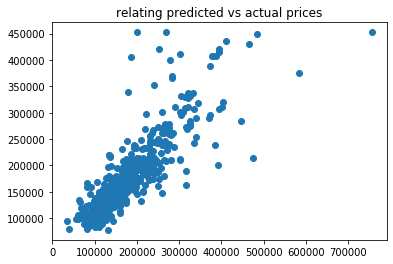

In [27]:
fig, ax = plt.subplots()
ax.scatter(y_test,y_hat )
ax.set_title('relating predicted vs actual prices')

# let's try to optimize our parameters adding a grid search step

In [29]:
from sklearn.model_selection import GridSearchCV
estimator = lightgbm.LGBMRegressor()

param_grid = {
    '(num_leaves':[30, 45,50],
    'learning_rate': [0.1, 0.15, 0.20,0.25],
    'n_estimators': [15, 20, 40]
}

gridSearch = GridSearchCV(estimator, param_grid, cv=6)
gridSearch.fit(x_train, y_train)

print('Best parameters found by grid search are:', gridSearch.best_params_)

Best parameters found by grid search are: {'(num_leaves': 30, 'learning_rate': 0.15, 'n_estimators': 20}


In [30]:
pd.DataFrame(gridSearch.cv_results_).sort_values('mean_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_(num_leaves,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021924,0.023104,0.003989,0.000466,30,0.1,15,"{'(num_leaves': 30, 'learning_rate': 0.1, 'n_e...",0.663614,0.683637,0.489312,0.691551,0.692729,0.705578,0.654404,0.074902,34
24,0.011467,0.000802,0.003744,0.000330,50,0.1,15,"{'(num_leaves': 50, 'learning_rate': 0.1, 'n_e...",0.663614,0.683637,0.489312,0.691551,0.692729,0.705578,0.654404,0.074902,34
12,0.018016,0.009362,0.005026,0.002566,45,0.1,15,"{'(num_leaves': 45, 'learning_rate': 0.1, 'n_e...",0.663614,0.683637,0.489312,0.691551,0.692729,0.705578,0.654404,0.074902,34
23,0.021859,0.000675,0.003691,0.000166,45,0.25,40,"{'(num_leaves': 45, 'learning_rate': 0.25, 'n_...",0.705272,0.729364,0.431960,0.701895,0.759677,0.771289,0.683243,0.115252,31
11,0.021609,0.000482,0.003772,0.000211,30,0.25,40,"{'(num_leaves': 30, 'learning_rate': 0.25, 'n_...",0.705272,0.729364,0.431960,0.701895,0.759677,0.771289,0.683243,0.115252,31
35,0.027158,0.002950,0.004670,0.000533,50,0.25,40,"{'(num_leaves': 50, 'learning_rate': 0.25, 'n_...",0.705272,0.729364,0.431960,0.701895,0.759677,0.771289,0.683243,0.115252,31
13,0.013600,0.000858,0.003618,0.000192,45,0.1,20,"{'(num_leaves': 45, 'learning_rate': 0.1, 'n_e...",0.695744,0.720942,0.494488,0.717233,0.738316,0.740532,0.684543,0.086281,28
25,0.014893,0.001232,0.004106,0.000355,50,0.1,20,"{'(num_leaves': 50, 'learning_rate': 0.1, 'n_e...",0.695744,0.720942,0.494488,0.717233,0.738316,0.740532,0.684543,0.086281,28
1,0.013562,0.000888,0.003746,0.000364,30,0.1,20,"{'(num_leaves': 30, 'learning_rate': 0.1, 'n_e...",0.695744,0.720942,0.494488,0.717233,0.738316,0.740532,0.684543,0.086281,28
20,0.022524,0.001033,0.003940,0.000450,45,0.2,40,"{'(num_leaves': 45, 'learning_rate': 0.2, 'n_e...",0.714598,0.737647,0.453526,0.721519,0.768233,0.764057,0.693263,0.109033,25


## How does this first simple lgbt model compare to a basic multivariate linear regression

In [31]:
from sklearn.linear_model import LinearRegression
model1 = LinearRegression()
model1.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
y_hat1 = model1.predict(x_test)
print('the RMSE is ... {}\nthe MAE is ... {}'.format(mse(y_hat1,y_test)**.5,mae(y_hat1,y_test)))

the RMSE is ... 50575.8131587197
the MAE is ... 35107.419880719906


Text(0.5, 1.0, 'relating predicted vs actual prices')

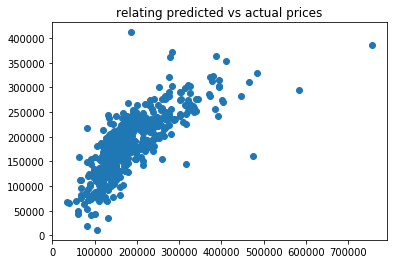

In [33]:
fig, ax = plt.subplots()
ax.scatter(y_test,y_hat1 )
ax.set_title('relating predicted vs actual prices')

This quick prototyping shows that:
    - With just a limited number of well selected features lgbt is good enough
      to give us an Idea of the trend
    - lightgbt perform much better than a linear regression
    - we need to add other relevant features to 
      account for the 30% missing in predictions
    - This model used only 11 o the 80 available features, i.e. around 15% of the 
      available data and still the model is performant, showing that sofar we are 
      doing a good job.. so let's continue it...

In [ ]:
# if __name__ == '__main__':
#     n = int(input().strip())